In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno
from scipy import stats 
import matplotlib.font_manager as fm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor



k_fold = KFold(n_splits=10,shuffle=True,random_state=0)


# NoteBook 안에 그래프를 위해(?)
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')


#  그래프에서 격자로 숫자 범위가 잘 띄게
plt.style.use('ggplot')

In [2]:
#  parse_dates 를 datetime 으로 하면 datetime 식으로 불러온다... 아직 무슨말인지 잘 모르겠음
train = pd.read_csv('data/train.csv', parse_dates=['datetime'])
test = pd.read_csv('data/test.csv', parse_dates=['datetime'])


# Feature Engineering

In [3]:
train['year']=train['datetime'].dt.year
train['month']=train['datetime'].dt.month
train['day']=train['datetime'].dt.day
train['hour']=train['datetime'].dt.hour
train['minute']=train['datetime'].dt.minute
train['second']=train['datetime'].dt.second
train['dayofweek']=train['datetime'].dt.dayofweek
train.shape


(10886, 19)

In [4]:
test['year']=test['datetime'].dt.year
test['month']=test['datetime'].dt.month
test['day']=test['datetime'].dt.day
test['hour']=test['datetime'].dt.hour
test['minute']=test['datetime'].dt.minute
test['second']=test['datetime'].dt.second
test['dayofweek']=test['datetime'].dt.dayofweek
test.shape

(6493, 16)

* 풍속 data 시각화

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

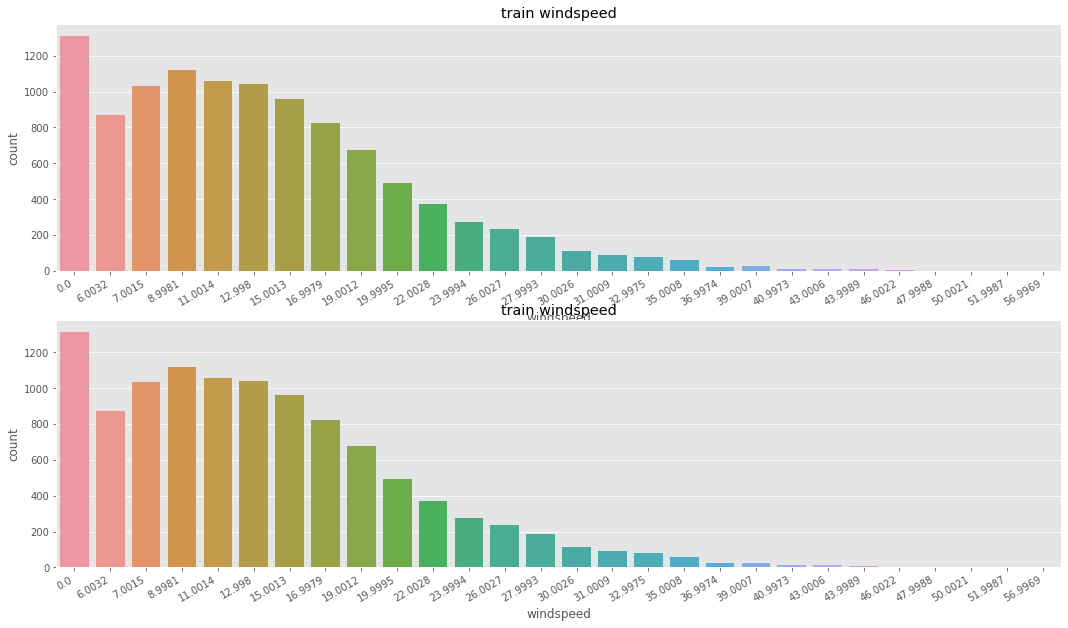

In [5]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30,ha='right')
axes[0].set(ylabel='Count',title='train windspeed')
sns.countplot(data=train,x='windspeed',ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30,ha='right')
axes[1].set(ylabel='Count',title='train windspeed')
sns.countplot(data=train,x='windspeed',ax=axes[1])


* 확인결과 측정하지 않은 값을 모두 0으로 넣어주었다고 판단 됨.
* 따라서 해당 데이터를 평균값을 넣는 방법도 있지만, 머신러닝을 통해 예측하여 풍속을 넣어주고자 함.


In [6]:
def predict_windspeed(data):
    # 풍속이 0인것과 아닌것 구분
    dataWind0 = data.loc[data['windspeed']==0]
    dataWindNot0 = data.loc[data['windspeed']!=0]

    # 풍속 예측을 위해 사용될 피쳐 선택
    wCol = ['season','weather','humidity','month','temp','year','atemp']

    # 풍속이 0이 아닌 타입을 str로 바꾸기
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')

    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처값을 바탕으로 풍속 학습
    rfModel_wind.fit(dataWindNot0[wCol],dataWindNot0['windspeed'])

    # 학습값 바탕으로 풍속 0 의 풍속값 예측
    wind0Values = rfModel_wind.predict(X=dataWind0[wCol])

    # 값 예측 후 비교위해 예측값을 넣어 줄 데이터 프레임 새로 짜기
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측값 넣어주기
    predictWind0['windspeed'] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터 프레임에 예측값 프레임을 합치기
    data = predictWindNot0.append(predictWind0)

    data['windspeed'] = data['windspeed'].astype(float)

    data.reset_index(inplace=True)
    data.drop('index',inplace=True,axis=1)

    return data

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

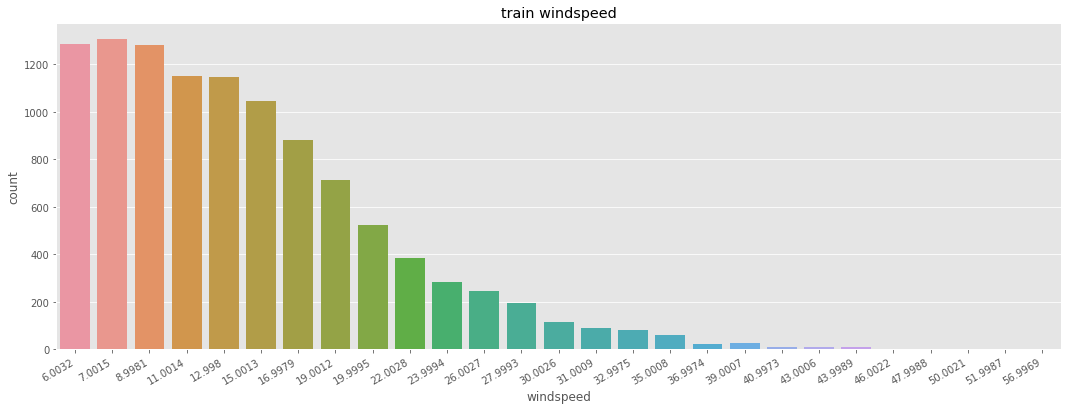

In [7]:
# 0 값 조정.
train = predict_windspeed(train)

fig , axl = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(axl)
plt.xticks(rotation=30,ha='right')
axl.set(ylabel='Count',title='train windspeed')
sns.countplot(data=train, x= 'windspeed',ax=axl)



# Feature Selection
* 신호와 잡음의 구분 필요성
* 많은 피처수가 높은 신뢰성을 대변하지 않음
* 피처를 하나씩 추가해가며 비교 후 성능이 좋지 않은 피처를 삭제


In [8]:
# 연속형 feature와 범주형 feature
# 연속형 feature = ['temp','humidity','windspeed','atemp']
# 범주형 feature의 type 을 category 로 변경해준다.

categorical_feature_names = ['season','holiday','workingday','weather','dayofweek','month','year','hour']

for var in categorical_feature_names:
    train[var] =train[var].astype('category')
    test[var] =test[var].astype('category')

In [9]:
feature_names = ['season','holiday','windspeed','temp','atemp','humidity','workingday','weather','dayofweek','year','hour']

feature_names

['season',
 'holiday',
 'windspeed',
 'temp',
 'atemp',
 'humidity',
 'workingday',
 'weather',
 'dayofweek',
 'year',
 'hour']

In [10]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,holiday,windspeed,temp,atemp,humidity,workingday,weather,dayofweek,year,hour
0,1,0,6.0032,9.84,12.880,75,0,2,5,2011,5
1,1,0,16.9979,15.58,19.695,76,0,1,5,2011,10
2,1,0,19.0012,14.76,16.665,81,0,1,5,2011,11
3,1,0,19.0012,17.22,21.210,77,0,1,5,2011,12
4,1,0,19.9995,18.86,22.725,72,0,2,5,2011,13


In [11]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,holiday,windspeed,temp,atemp,humidity,workingday,weather,dayofweek,year,hour
0,1,0,26.0027,10.66,11.365,56,1,1,3,2011,0
1,1,0,0.0000,10.66,13.635,56,1,1,3,2011,1
2,1,0,0.0000,10.66,13.635,56,1,1,3,2011,2
3,1,0,11.0014,10.66,12.880,56,1,1,3,2011,3
4,1,0,11.0014,10.66,12.880,56,1,1,3,2011,4


In [12]:
label_name ='count'

y_train = train[label_name]

print(y_train.shape)
y_train.head()


(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# Score

# RMSLE

과대평가보다는 과소평가 된 항목에 패널티 주기

Error 를 제곱해서 평균한 값의 제곱근으로 값이 작을수록( 0 에 가까울수록 ) 정밀도가 높다.





In [13]:
def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [14]:
max_depth_list = []

model = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=0)
#  n_estimators 값을 높일수록 더욱 신뢰성 높은 값을 줌. 하지만 그만큼 시간이 오래걸림


model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [15]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

Wall time: 4.54 s
Score= 0.33086
